In [1]:
import sys
sys.path.append("../")

In [2]:
from mir.common import Repertoire, ImmrepParser, SegmentLibrary
from mir.embedding.prototype_embedding import PrototypeEmbedding
from mir.distances.aligner import ClonotypeAligner
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [4]:
from collections import defaultdict

# Prototype embeddings generation

In [36]:
pd.read_csv('assets/immrep23_data.csv').dropna().to_csv('assets/immrep23_data.csv', index=False)

In [99]:
proto_repertoire = Repertoire.load(parser=ImmrepParser(column_mapping={
                                                                        'epitope': 'antigen.epitope',
                                                                        'mhc.a': 'mhc.a',
                                                                        'Va': 'v.alpha',
                                                                        'Ja': 'j.alpha',
                                                                        'cdr3a': 'cdr3.alpha',
                                                                        'Vb': 'v.beta',
                                                                        'Jb': 'j.beta',
                                                                        'cdr3b': 'cdr3.beta',
                                                                    }),
                                   n=5000,
                                   sample=True, 
                                   path='assets/vdjdb_full_alpha_beta.txt')

In [109]:
proto_repertoire[0].chainA.payload

{'HLA': 'HLA-DQA1*05:01', 'epitope': 'PQPELPYPQPQL'}

In [110]:
epi_to_number = defaultdict(int)
for clone in proto_repertoire:
    epi_to_number[clone.chainA.payload['epitope']] += 1

In [45]:
analysis_repertoire = Repertoire.load(parser=ImmrepParser(column_mapping={
                                                                        'epitope': 'Peptide',
                                                                        'mhc.a': 'HLA',
                                                                        'Va': 'Va',
                                                                        'Ja': 'Ja',
                                                                        'cdr3a': 'CDR3a',
                                                                        'Vb': 'Vb',
                                                                        'Jb': 'Jb',
                                                                        'cdr3b': 'CDR3b'}, 
                                                            sep=','),
                                      path='assets/immrep23_data.csv')

In [46]:
proto_repertoire

Repertoire of 5000 clonotypes and 5000 cells:
alpha κ-1 CIVYNNNDMRF beta κ-1 CASSIRSTDTQYF
alpha κ-1 CAMRYRGRGGSNYKLTF beta κ-1 CASTELLAEYIDTQYF
alpha κ-1 CAENNTGRRALTF beta κ-1 CASSLFDNEQFF
alpha κ-1 CADSGGGADGLTF beta κ-1 CASSQDRGGPGELFF
alpha κ-1 CAASETSYDKVIF beta κ-1 CASSPPGGGNTGELFF
{'path': 'assets/immrep23_data.csv'}
...

In [47]:
analysis_repertoire

Repertoire of 14794 clonotypes and 14794 cells:
alpha κ-1 AASETSYDKVI beta κ-1 ASSFSGNTGELF
alpha κ-1 VVESGGSYIPT beta κ-1 ASSARSSYEQY
alpha κ-1 ILREFYNDMR beta κ-1 ASSLGTSGGTGELF
alpha κ-1 AGAKETSYDKVI beta κ-1 ASSSAAAYEQY
alpha κ-1 ATDASGGSNYKLT beta κ-1 SVGTGDWGEQY
{'path': 'assets/immrep23_data.csv'}
...

In [48]:
analysis_repertoire.total()

14794

In [49]:
embedding_maker = PrototypeEmbedding(proto_repertoire, aligner = ClonotypeAligner.from_library(lib=SegmentLibrary.load_from_imgt()))

In [50]:
import time

In [51]:
t0 = time.time()
embeddings = embedding_maker.embed_repertoire(analysis_repertoire, threads=32, flatten_scores=True)
print(f'finished {analysis_repertoire.total()} clones in {time.time() - t0}')

finished 14794 clones in 1502.9571633338928


In [52]:
column_names = []
for i in range(proto_repertoire.total()):
    column_names += [f'{i}_a_v', f'{i}_a_j', f'{i}_a_cdr3', f'{i}_b_v', f'{i}_b_j', f'{i}_b_cdr3']

In [53]:
pd.DataFrame(embeddings, columns=column_names).to_csv('prototype_embeddings_for_immrep_data.csv', index=False)

# Analysis of resulting embeddings

In [4]:
embeddings = pd.read_csv('prototype_embeddings_for_immrep_data.csv')

In [5]:
# embeddings = embeddings[[x for x in embeddings.columns if 'cdr' in x]]

In [6]:
immrep_data = pd.read_csv('assets/immrep23_data.csv')

In [7]:
immrep_labels = pd.read_csv('assets/immrep23_with_labels.csv')

In [8]:
immrep_data.head()

,Peptide,HLA,Va,Ja,TCRa,CDR1a,CDR2a,CDR3a,CDR3a_extended,Vb,Jb,TCRb,CDR1b,CDR2b,CDR3b,CDR3b_extended
0,RAKFKQLL,HLA-B*08:01,TRAV13-1*01,TRAJ50*01,MTSIRAVFIFLWLQLDLVNGENVEQHPSTLSVQEGDSAVIKCTYSD...,DSASNY,IRSNVGE,AASETSYDKVI,CAASETSYDKVIF,TRBV12-3*01,TRBJ2-2*01,MDSWTFCCVSLCILVAKHTDAGVIQSPRHEVTEMGQEVTLRCKPIS...,SGHNS,FNNNVP,ASSFSGNTGELF,CASSFSGNTGELFF
1,GILGFVFTL,HLA-A*02:01,TRAV12-1*01,TRAJ6*01,MISLRVLLVILWLQLSWVWSQRKEVEQDPGPFNVPEGATVAFNCTY...,NSASQS,VYSSG,VVESGGSYIPT,CVVESGGSYIPTF,TRBV19*01,TRBJ2-7*01,MSNQVLCCVVLCFLGANTVDGGITQSPKYLFRKEGQNVTLSCEQNL...,LNHDA,SQIVND,ASSARSSYEQY,CASSARSSYEQYF
2,RAKFKQLL,HLA-B*08:01,TRAV26-2*01,TRAJ43*01,MKLVTSITVLLSLGIMGDAKTTQPNSMESNEEEPVHLPCNHSTISG...,TISGTDY,GLTSN,ILREFYNDMR,CILREFYNDMRF,TRBV7-3*01,TRBJ2-2*01,MGTRLLCWAALCLLGADHTGAGVSQTPSNKVTEKGKYVELRCDPIS...,SGHTA,FQGTGA,ASSLGTSGGTGELF,CASSLGTSGGTGELFF
3,RAKFKQLL,HLA-B*08:01,TRAV27*01,TRAJ50*01,MVLKFSVSILWIQLAWVSTQLLEQSPQFLSIQEGENLTVYCNSSSV...,SVFSS,VVTGGEV,AGAKETSYDKVI,CAGAKETSYDKVIF,TRBV7-9*01,TRBJ2-7*01,MGTSLLCWMALCLLGADHADTGVSQNPRHKITKRGQNVTFRCDPIS...,SEHNR,FQNEAQ,ASSSAAAYEQY,CASSSAAAYEQYF
4,RAKFKQLL,HLA-B*08:01,TRAV17*01,TRAJ53*01,METLLGVSLVILWLQLARVNSQQGEEDPQALSIQEGENATMNCSYK...,TSINN,IRSNERE,ATDASGGSNYKLT,CATDASGGSNYKLTF,TRBV29-1*01,TRBJ2-7*01,MLSLLLLLLGLGSVFSAVISQKPSRDICQRGTSLTIQCQVDSQVTM...,SQVTM,ANQGSEA,SVGTGDWGEQY,CSVGTGDWGEQYF


In [9]:
immrep_data = immrep_data.merge(immrep_labels).drop(columns=['ID'])

In [10]:
immrep_data['is_train_sample'] = immrep_data.Target.apply(lambda x: x == 1)

In [11]:
immrep_data['is_train_sample'].value_counts()

is_train_sample
True     11310
False     3484
Name: count, dtype: int64

In [12]:
immrep_data.Target = immrep_data.apply(lambda x: x.Peptide if x.is_train_sample else 'Unknown', axis=1)

In [13]:
immrep_data.Target.value_counts().head(10)

Target
Unknown       3484
GILGFVFTL     1818
RAKFKQLL      1064
KLGGALQAK      912
AVFDRKSDAK     732
YLQPRTFLL      434
ELAGIGILTV     432
NLVPMVATV      390
TTDPSFLGRY     384
SPRWYFYYL      364
Name: count, dtype: int64

In [125]:
immrep_data.Target.value_counts() < 2

Target
Unknown       False
GILGFVFTL     False
RAKFKQLL      False
KLGGALQAK     False
AVFDRKSDAK    False
              ...  
RARSVASQSI     True
MEVDPIGHLY     True
KIYSKHTPI      True
YTDINGNLH      True
TLATHGLAAV     True
Name: count, Length: 809, dtype: bool

In [14]:
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = TSNE(n_components=2)
components = pca.fit_transform(embeddings)


In [15]:
components[:, 0]

array([-74.20638 ,  67.21404 , -60.740612, ..., -55.44103 , -67.0233  ,
       -35.508106], dtype=float32)

In [16]:
resulting_df = pd.DataFrame({'c1': components[:, 0], 'c2': components[:, 1], 'target': immrep_data.Target})

In [17]:
import seaborn as sns

In [18]:
resulting_df['plotting_target'] = resulting_df.target.apply(lambda x: x if x in ['GILGFVFTL', 'Unknown'] else 'other')

<Axes: xlabel='c1', ylabel='c2'>

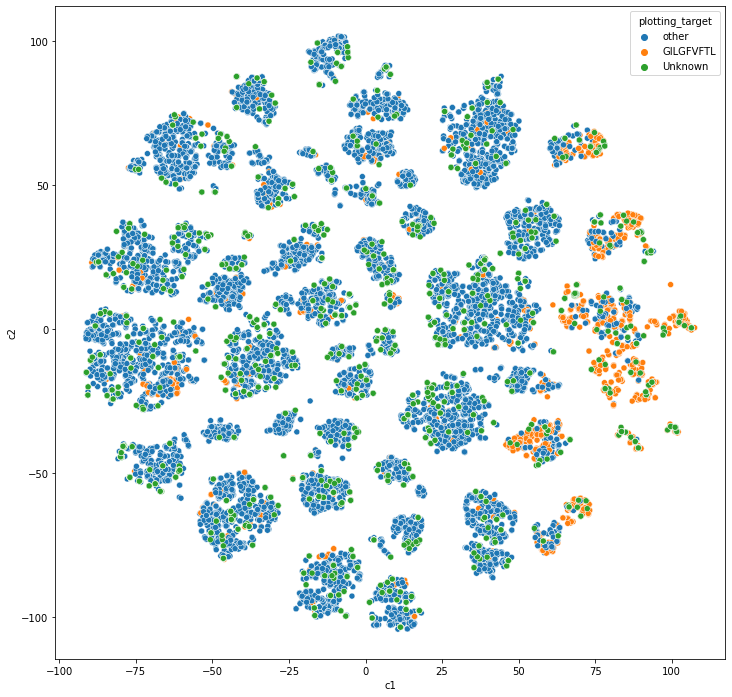

In [19]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(resulting_df, x='c1', y='c2', hue='plotting_target')

In [23]:
embeddings

,0_a_v,0_a_j,0_a_cdr3,0_b_v,0_b_j,0_b_cdr3,1_a_v,1_a_j,1_a_cdr3,1_b_v,...,4998_a_cdr3,4998_b_v,4998_b_j,4998_b_cdr3,4999_a_v,4999_a_j,4999_a_cdr3,4999_b_v,4999_b_j,4999_b_cdr3
0,76.0,-11.0,30.0,294.0,-21.0,-40.0,89.0,-16.0,-100.0,294.0,...,-170.0,136.0,96.0,-90.0,63.0,-6.0,-150.0,147.0,-26.0,-100.0
1,55.0,-26.0,-40.0,155.0,-25.0,-70.0,93.0,-27.0,-220.0,171.0,...,-170.0,290.0,-31.0,-70.0,58.0,-18.0,-130.0,277.0,-27.0,-80.0
2,337.0,88.0,-40.0,403.0,-21.0,-10.0,96.0,-4.0,-170.0,326.0,...,-110.0,94.0,96.0,-20.0,261.0,2.0,-190.0,102.0,-26.0,-100.0
3,60.0,-11.0,-40.0,322.0,-25.0,-50.0,83.0,-16.0,-70.0,507.0,...,-70.0,139.0,-31.0,-40.0,60.0,-6.0,-210.0,120.0,-27.0,-30.0
4,76.0,-4.0,-10.0,149.0,-25.0,-120.0,121.0,95.0,-100.0,127.0,...,-60.0,82.0,-31.0,-90.0,56.0,-3.0,90.0,91.0,-27.0,-80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14789,94.0,-11.0,20.0,157.0,-23.0,-70.0,322.0,-16.0,-130.0,157.0,...,-180.0,125.0,-31.0,-70.0,86.0,-6.0,-210.0,129.0,-18.0,60.0
14790,494.0,-9.0,-40.0,403.0,84.0,30.0,100.0,-15.0,-60.0,326.0,...,-150.0,94.0,-21.0,-70.0,276.0,-12.0,40.0,102.0,-20.0,50.0
14791,55.0,-17.0,-40.0,290.0,-19.0,-60.0,93.0,-2.0,-160.0,288.0,...,-150.0,135.0,-16.0,20.0,58.0,-13.0,-50.0,158.0,-24.0,-140.0
14792,494.0,-5.0,-80.0,403.0,84.0,-30.0,100.0,-16.0,-230.0,326.0,...,-60.0,94.0,-21.0,-90.0,276.0,-17.0,-100.0,102.0,-20.0,-40.0


In [21]:
from sklearn.preprocessing import StandardScaler

In [22]:
scaled_embeddings = StandardScaler().fit_transform(embeddings)
scaled_embeddings = pd.DataFrame(scaled_embeddings, columns=embeddings.columns)

In [24]:
scaled_embeddings

,0_a_v,0_a_j,0_a_cdr3,0_b_v,0_b_j,0_b_cdr3,1_a_v,1_a_j,1_a_cdr3,1_b_v,...,4998_a_cdr3,4998_b_v,4998_b_j,4998_b_cdr3,4999_a_v,4999_a_j,4999_a_cdr3,4999_b_v,4999_b_j,4999_b_cdr3
0,-0.100471,-0.135478,0.989150,1.170664,-0.339492,0.350475,-0.489775,-0.119216,0.446197,0.910438,...,-0.612028,-0.592907,2.747834,-0.570554,-0.207372,0.259273,-0.372609,-0.478995,-0.362544,-0.592234
1,-0.407770,-0.807672,-0.453710,-0.467489,-0.463775,-0.233304,-0.445815,-0.654036,-0.838301,-0.316013,...,-0.612028,0.938320,-0.563970,-0.253202,-0.275296,-0.318688,-0.144036,0.688923,-0.400148,-0.266473
2,3.718808,4.301003,-0.453710,2.455259,-0.339492,0.934254,-0.412845,0.464223,-0.303094,1.229515,...,0.518941,-1.010514,2.747834,0.540179,2.482434,0.644580,-0.829754,-0.883274,-0.362544,-0.592234
3,-0.334603,-0.135478,-0.453710,1.500652,-0.463775,0.155882,-0.555716,-0.119216,0.767321,3.034293,...,1.272920,-0.563078,-0.563970,0.222827,-0.248126,0.259273,-1.058327,-0.721562,-0.400148,0.547930
4,-0.100471,0.178213,0.164659,-0.538201,-0.463775,-1.206268,-0.138094,5.277595,0.446197,-0.754744,...,1.461415,-1.129830,-0.563970,-0.570554,-0.302466,0.403763,2.370264,-0.982098,-0.400148,-0.266473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14789,0.162927,-0.135478,0.783028,-0.443919,-0.401633,-0.233304,2.070901,-0.119216,0.125072,-0.455610,...,-0.800523,-0.702280,-0.563970,-0.253202,0.105080,0.259273,-1.058327,-0.640706,-0.061713,2.013856
14790,6.016230,-0.045852,-0.453710,2.455259,2.922925,1.712625,-0.368885,-0.070596,0.874363,1.229515,...,-0.235039,-1.010514,-0.303198,-0.253202,2.686207,-0.029707,1.798832,-0.883274,-0.136921,1.850975
14791,-0.407770,-0.404355,-0.453710,1.123523,-0.277351,-0.038711,-0.445815,0.561462,-0.196052,0.850611,...,-0.235039,-0.602850,-0.172812,1.174884,-0.275296,-0.077871,0.770255,-0.380171,-0.287336,-1.243757
14792,6.016230,0.133400,-1.278202,2.455259,2.922925,0.545068,-0.368885,-0.119216,-0.945342,1.229515,...,1.461415,-1.010514,-0.303198,-0.570554,2.686207,-0.270524,0.198823,-0.883274,-0.136921,0.385050


In [25]:
pca_scaled = TSNE(n_components=2)
components = pca.fit_transform(scaled_embeddings)

In [80]:
immrep_data.Target.value_counts().head(10)

Target
Unknown       3484
GILGFVFTL     1818
RAKFKQLL      1064
KLGGALQAK      912
AVFDRKSDAK     732
YLQPRTFLL      434
ELAGIGILTV     432
NLVPMVATV      390
TTDPSFLGRY     384
SPRWYFYYL      364
Name: count, dtype: int64

In [26]:
resulting_df_scaled = pd.DataFrame({'c1': components[:, 0], 'c2': components[:, 1], 'target': immrep_data.Target})

In [81]:
resulting_df_scaled['plotting_target'] = resulting_df_scaled.target.apply(lambda x: x if x in immrep_data.Target.value_counts().head(10) else 'other')

<Axes: xlabel='c1', ylabel='c2'>

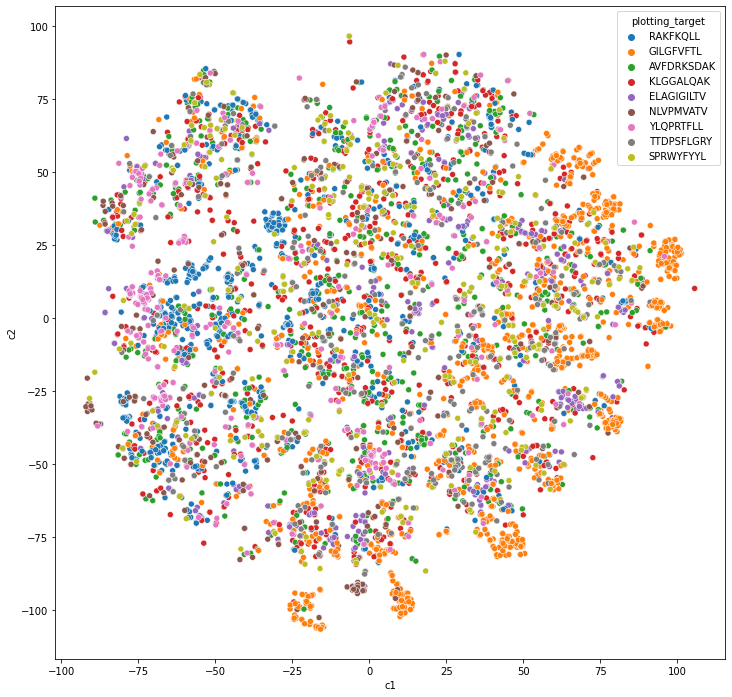

In [84]:
resulting_df_scaled['plotting_target'] = resulting_df_scaled.target.apply(lambda x: x if x in immrep_data.Target.value_counts().head(10) else 'other')
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(resulting_df_scaled[~resulting_df_scaled.plotting_target.isin(['Unknown', 'other']) ], x='c1', y='c2', hue='plotting_target')

In [30]:
from sklearn.cluster import DBSCAN, HDBSCAN


In [70]:
clustering = DBSCAN(eps=110, min_samples=2).fit(scaled_embeddings)

In [71]:
clustering.labels_

array([  0,   1,  -1, ..., 272, 132, 625])

In [72]:
pd.Series(clustering.labels_).value_counts().head(10)

-1      7503
 5       961
 1       168
 8       107
 0        96
 12       94
 488      84
 7        54
 179      52
 466      50
Name: count, dtype: int64

In [74]:
immrep_data[(clustering.labels_ == 5) & (immrep_data.is_train_sample)].Peptide.value_counts()

Peptide
GILGFVFTL     679
ELAGIGILTV     11
RAKFKQLL       11
TTDPSFLGRY      9
KLGGALQAK       4
AVFDRKSDAK      3
GLCTLVAML       3
YLQPRTFLL       3
NLVPMVATV       2
GILGLVFTL       1
LLFGYPVYV       1
EAAGIGILTV      1
ALGIGILTV       1
CINGVCWTV       1
NLNCCSVPV       1
GILEFVFTL       1
IVTDFSVIK       1
HPVTKYIM        1
ALWEIQQVV       1
YTDFSSEII       1
VLLFLAFVV       1
Name: count, dtype: int64

In [76]:
immrep_data[(clustering.labels_ == 5) & (~immrep_data.is_train_sample)].Peptide.value_counts()

Peptide
GILGFVFTL      63
RAKFKQLL       27
VSDGGPNLY      25
EPLPQGQLTAY    22
NLVPMVATV      18
TDLGQNLLY      12
YVLDHLIVV      12
VTEHDTLLY       7
GLCTLVAML       6
VLEETSVML       5
SALPTNADLY      4
RPHERNGFTVL     4
IVTDFSVIK       4
RPPIFIRRL       3
TSDACMMTMY      3
IPSINVHHY       3
QIKVRVDMV       3
YLQPRTFLL       1
TPRVTGGGAM      1
FTDALGIDEY      1
Name: count, dtype: int64

# Analysis wo vj

In [86]:
pca = TSNE(n_components=2)
components = pca.fit_transform(scaled_embeddings[[x for x in scaled_embeddings.columns if 'cdr' in x]])


In [87]:
resulting_df_wo_vj = pd.DataFrame({'c1': components[:, 0], 'c2': components[:, 1], 'target': immrep_data.Target})

In [88]:
resulting_df_wo_vj['plotting_target'] = resulting_df_wo_vj.target.apply(lambda x: x if x in ['GILGFVFTL', 'Unknown'] else 'other')

<Axes: xlabel='c1', ylabel='c2'>

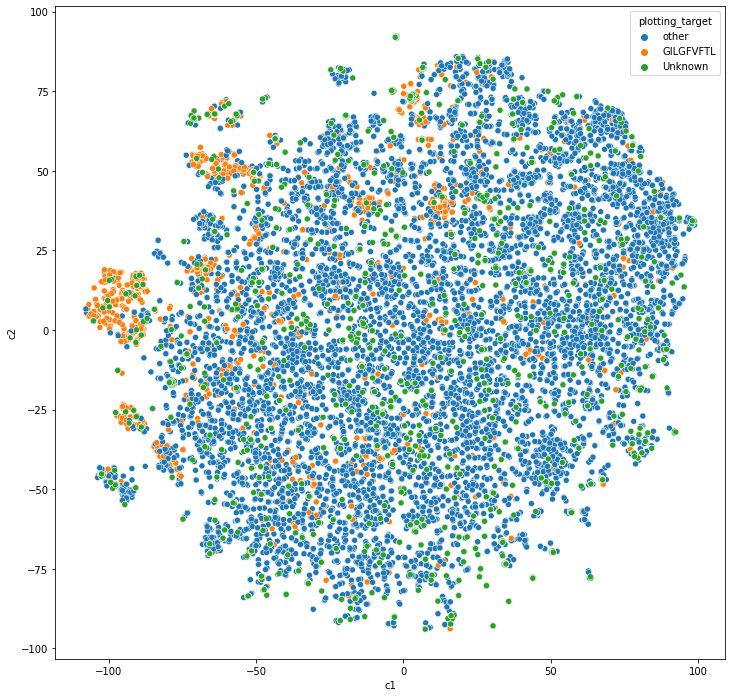

In [89]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(resulting_df_wo_vj, x='c1', y='c2', hue='plotting_target')

<Axes: xlabel='c1', ylabel='c2'>

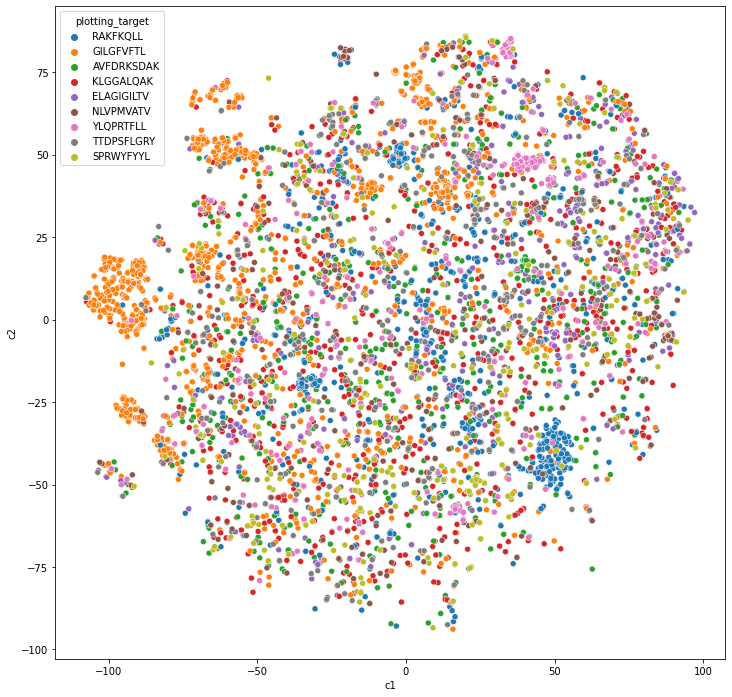

In [121]:
resulting_df_wo_vj['plotting_target'] = resulting_df_wo_vj.target.apply(lambda x: x if x in immrep_data.Target.value_counts().head(10) else 'other')
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(resulting_df_wo_vj[~resulting_df_wo_vj.plotting_target.isin(['Unknown', 'other']) ], x='c1', y='c2', hue='plotting_target')

In [92]:
clustering = DBSCAN(eps=50, min_samples=2).fit(scaled_embeddings[[x for x in scaled_embeddings.columns if 'cdr' in x]])

In [93]:
pd.Series(clustering.labels_).value_counts().head(10)

-1      8718
 1       714
 5       217
 6       106
 10       85
 304      66
 3        58
 283      53
 19       45
 257      44
Name: count, dtype: int64

In [98]:
immrep_data[(clustering.labels_ == 304) & (immrep_data.is_train_sample)].Peptide.value_counts()

Peptide
YLQPRTFLL    64
GILGFVFTL     1
LYALVYFLQ     1
Name: count, dtype: int64

# Analysis for beta only

In [35]:
pca = TSNE(n_components=2)
components = pca.fit_transform(embeddings[[x for x in embeddings.columns if 'b' in x]])

In [36]:
resulting_df_beta = pd.DataFrame({'c1': components[:, 0], 'c2': components[:, 1], 'target': immrep_data.Target})
resulting_df_beta['plotting_target'] = resulting_df_beta.target.apply(lambda x: x if x in ['GILGFVFTL', 'Unknown'] else 'other')

<Axes: xlabel='c1', ylabel='c2'>

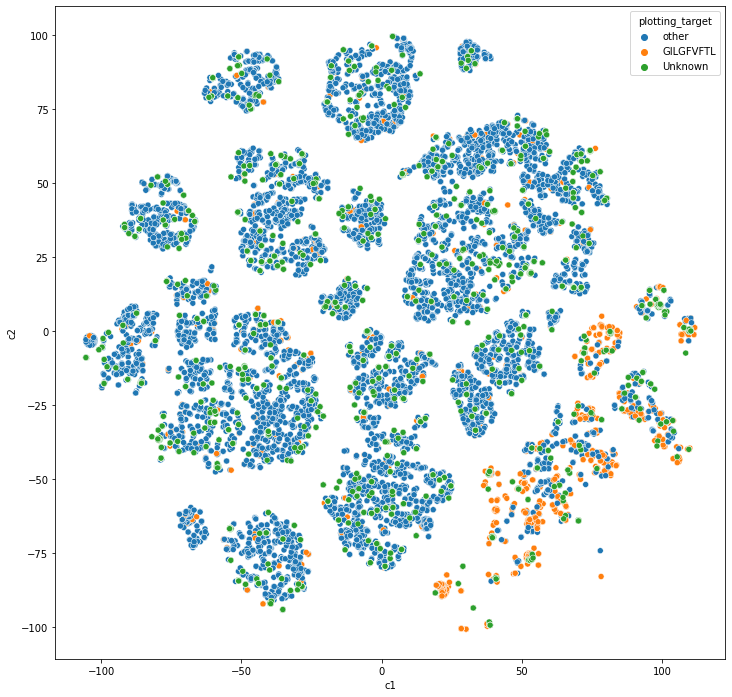

In [37]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(resulting_df_beta, x='c1', y='c2', hue='plotting_target')

# Analysis for alpha only

In [38]:
pca = TSNE(n_components=2)
components = pca.fit_transform(embeddings[[x for x in embeddings.columns if 'a' in x]])

In [39]:
resulting_df_alpha = pd.DataFrame({'c1': components[:, 0], 'c2': components[:, 1], 'target': immrep_data.Target})
resulting_df_alpha['plotting_target'] = resulting_df_alpha.target.apply(lambda x: x if x in ['GILGFVFTL', 'Unknown'] else 'other')

<Axes: xlabel='c1', ylabel='c2'>

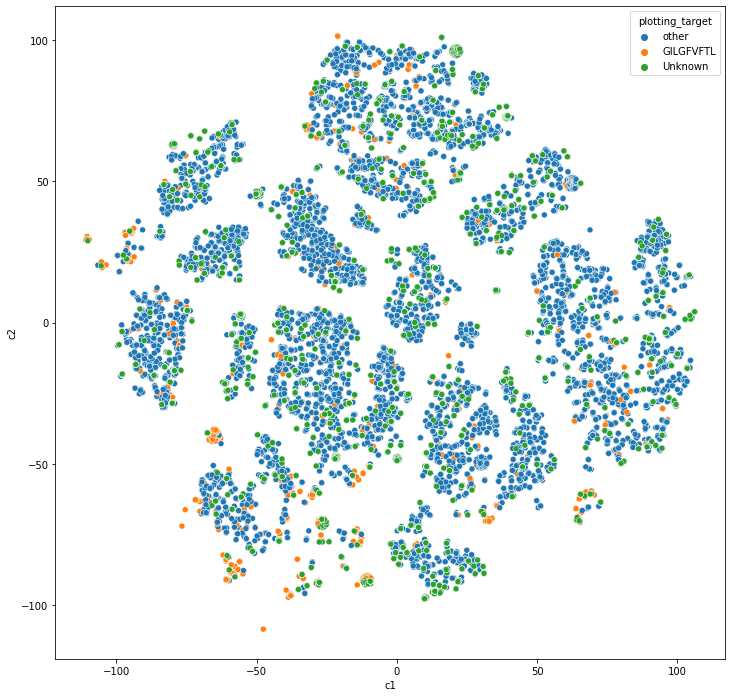

In [40]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(resulting_df_alpha, x='c1', y='c2', hue='plotting_target')